Датасет `bio.csv` містить дані про біоконцентрацію хімічних сполук. Ознаками є молекулярні дескриптори. Цільовою змінною є `logBCF`.

Датасет `bio_predict.csv` не містить значень цільової змінної і призначений для зовнішнього оцінювання.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (VotingRegressor, BaggingRegressor, AdaBoostRegressor, 
                              GradientBoostingRegressor, StackingRegressor, RandomForestRegressor)
import xgboost as xgb
import warnings

## Завдання 1

[3 бали] 


Імпортувати датасет `bio.csv` у об'єкт `DataFrame` і провести попередній аналіз даних засобами `pandas`, `matplotlib`, `seaborn`.  

In [2]:
df = pd.read_csv('bio.csv')
predict_df = pd.read_csv('bio_predict.csv')

df_info = df.info()
predict_df_info = predict_df.info()

df_info, predict_df_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679 entries, 0 to 678
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   nHM       679 non-null    int64  
 1   piPC09    679 non-null    float64
 2   PCD       679 non-null    float64
 3   X2Av      679 non-null    float64
 4   MLOGP     679 non-null    float64
 5   ON1V      679 non-null    float64
 6   N-072     679 non-null    int64  
 7   B02[C-N]  679 non-null    int64  
 8   F04[C-O]  679 non-null    int64  
 9   logBCF    679 non-null    float64
dtypes: float64(6), int64(4)
memory usage: 53.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   nHM       100 non-null    int64  
 1   piPC09    100 non-null    float64
 2   PCD       100 non-null    float64
 3   X2Av      100 non-null    float64
 4   MLOGP     100 non-null    float64


(None, None)

In [3]:
df.columns

Index(['nHM', 'piPC09', 'PCD', 'X2Av', 'MLOGP', 'ON1V', 'N-072', 'B02[C-N]',
       'F04[C-O]', 'logBCF'],
      dtype='object')

In [4]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679 entries, 0 to 678
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   nHM       679 non-null    int64  
 1   piPC09    679 non-null    float64
 2   PCD       679 non-null    float64
 3   X2Av      679 non-null    float64
 4   MLOGP     679 non-null    float64
 5   ON1V      679 non-null    float64
 6   N-072     679 non-null    int64  
 7   B02[C-N]  679 non-null    int64  
 8   F04[C-O]  679 non-null    int64  
 9   logBCF    679 non-null    float64
dtypes: float64(6), int64(4)
memory usage: 53.2 KB
None
              nHM      piPC09         PCD        X2Av       MLOGP        ON1V  \
count  679.000000  679.000000  679.000000  679.000000  679.000000  679.000000   
mean     1.823270    3.658184    1.561841    0.239588    3.245081    1.554507   
std      2.030299    2.966958    0.992019    0.155282    1.638216    0.850453   
min      0.000000    0.000000    0.000000    0.

In [5]:
print(df.isnull().sum())


nHM         0
piPC09      0
PCD         0
X2Av        0
MLOGP       0
ON1V        0
N-072       0
B02[C-N]    0
F04[C-O]    0
logBCF      0
dtype: int64


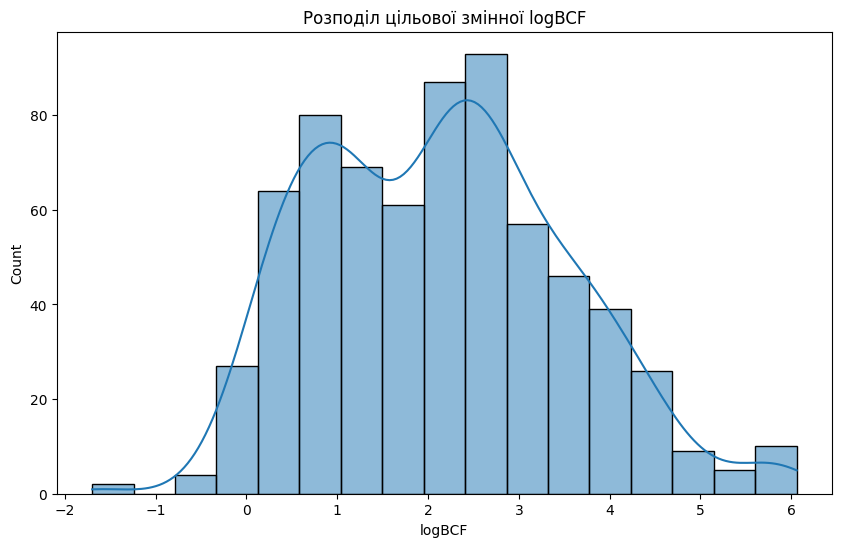

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(df['logBCF'], kde=True)
plt.title('Розподіл цільової змінної logBCF')
plt.show()

### Розподіл цільової змінної logBCF показує приблизно нормальний розподіл з невеликим нахилом вправо. Це свідчить про те, що більшість значень logBCF знаходяться в діапазоні від 1 до 4.

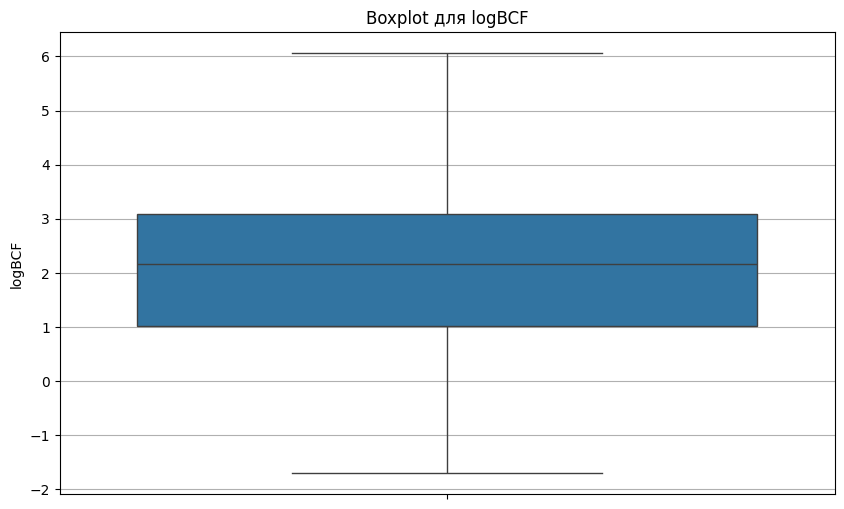

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=df['logBCF'], showfliers=True)  # Додано showfliers=True
plt.title('Boxplot для logBCF')
plt.ylabel('logBCF')
plt.grid(axis='y')  # Додано сітку для поліпшення читабельності
plt.show()

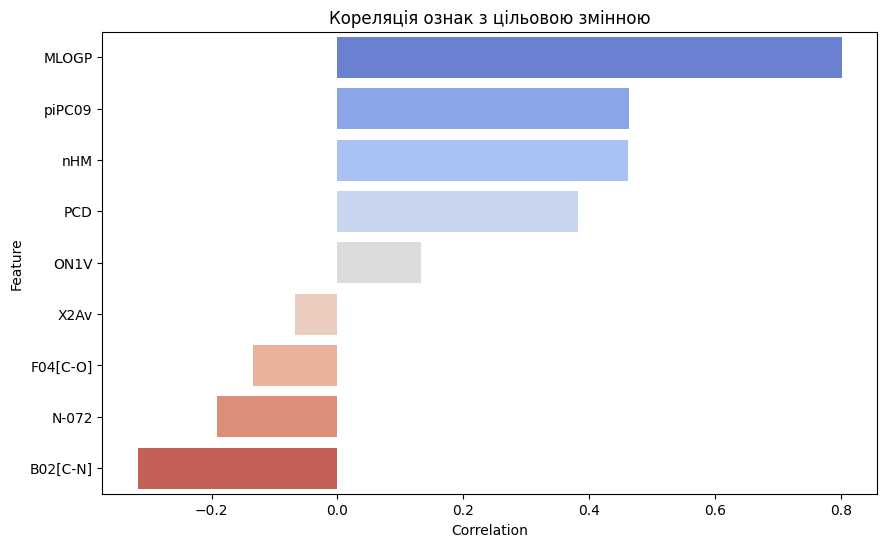

In [8]:
correlation = df.corr()['logBCF'].drop('logBCF')
warnings.filterwarnings('ignore')

correlation_df = pd.DataFrame({
    'Feature': correlation.index,
    'Correlation': correlation.values
})

correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Correlation', y='Feature', data=correlation_df, palette='coolwarm')
plt.title('Кореляція ознак з цільовою змінною')
plt.show()

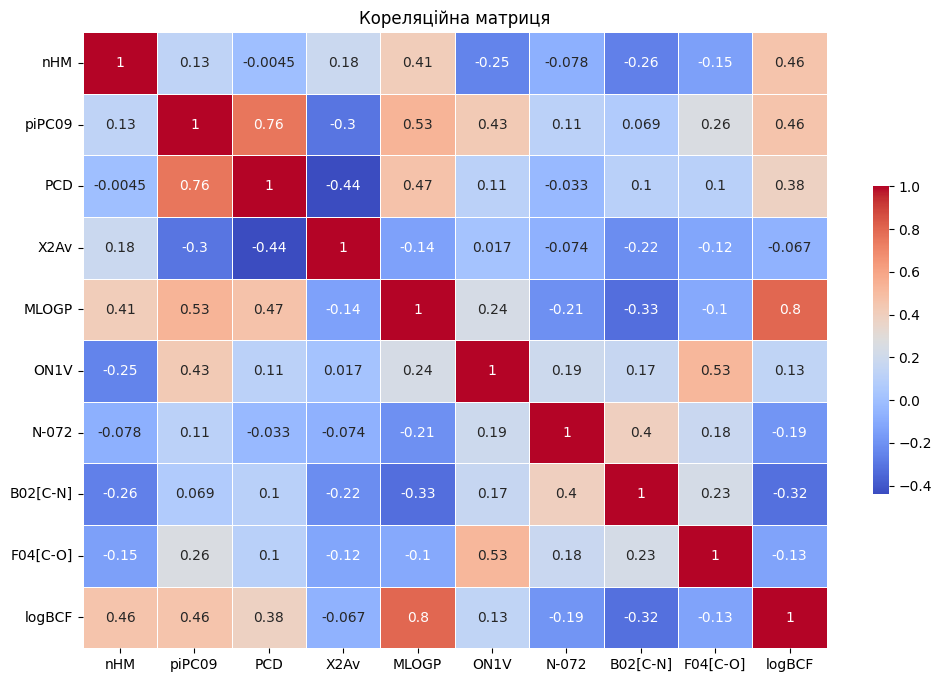

In [9]:
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, linewidths=0.5, cbar_kws={'shrink': 0.5}, cmap = 'coolwarm')
plt.title('Кореляційна матриця')
plt.show()

### Викиди ознак

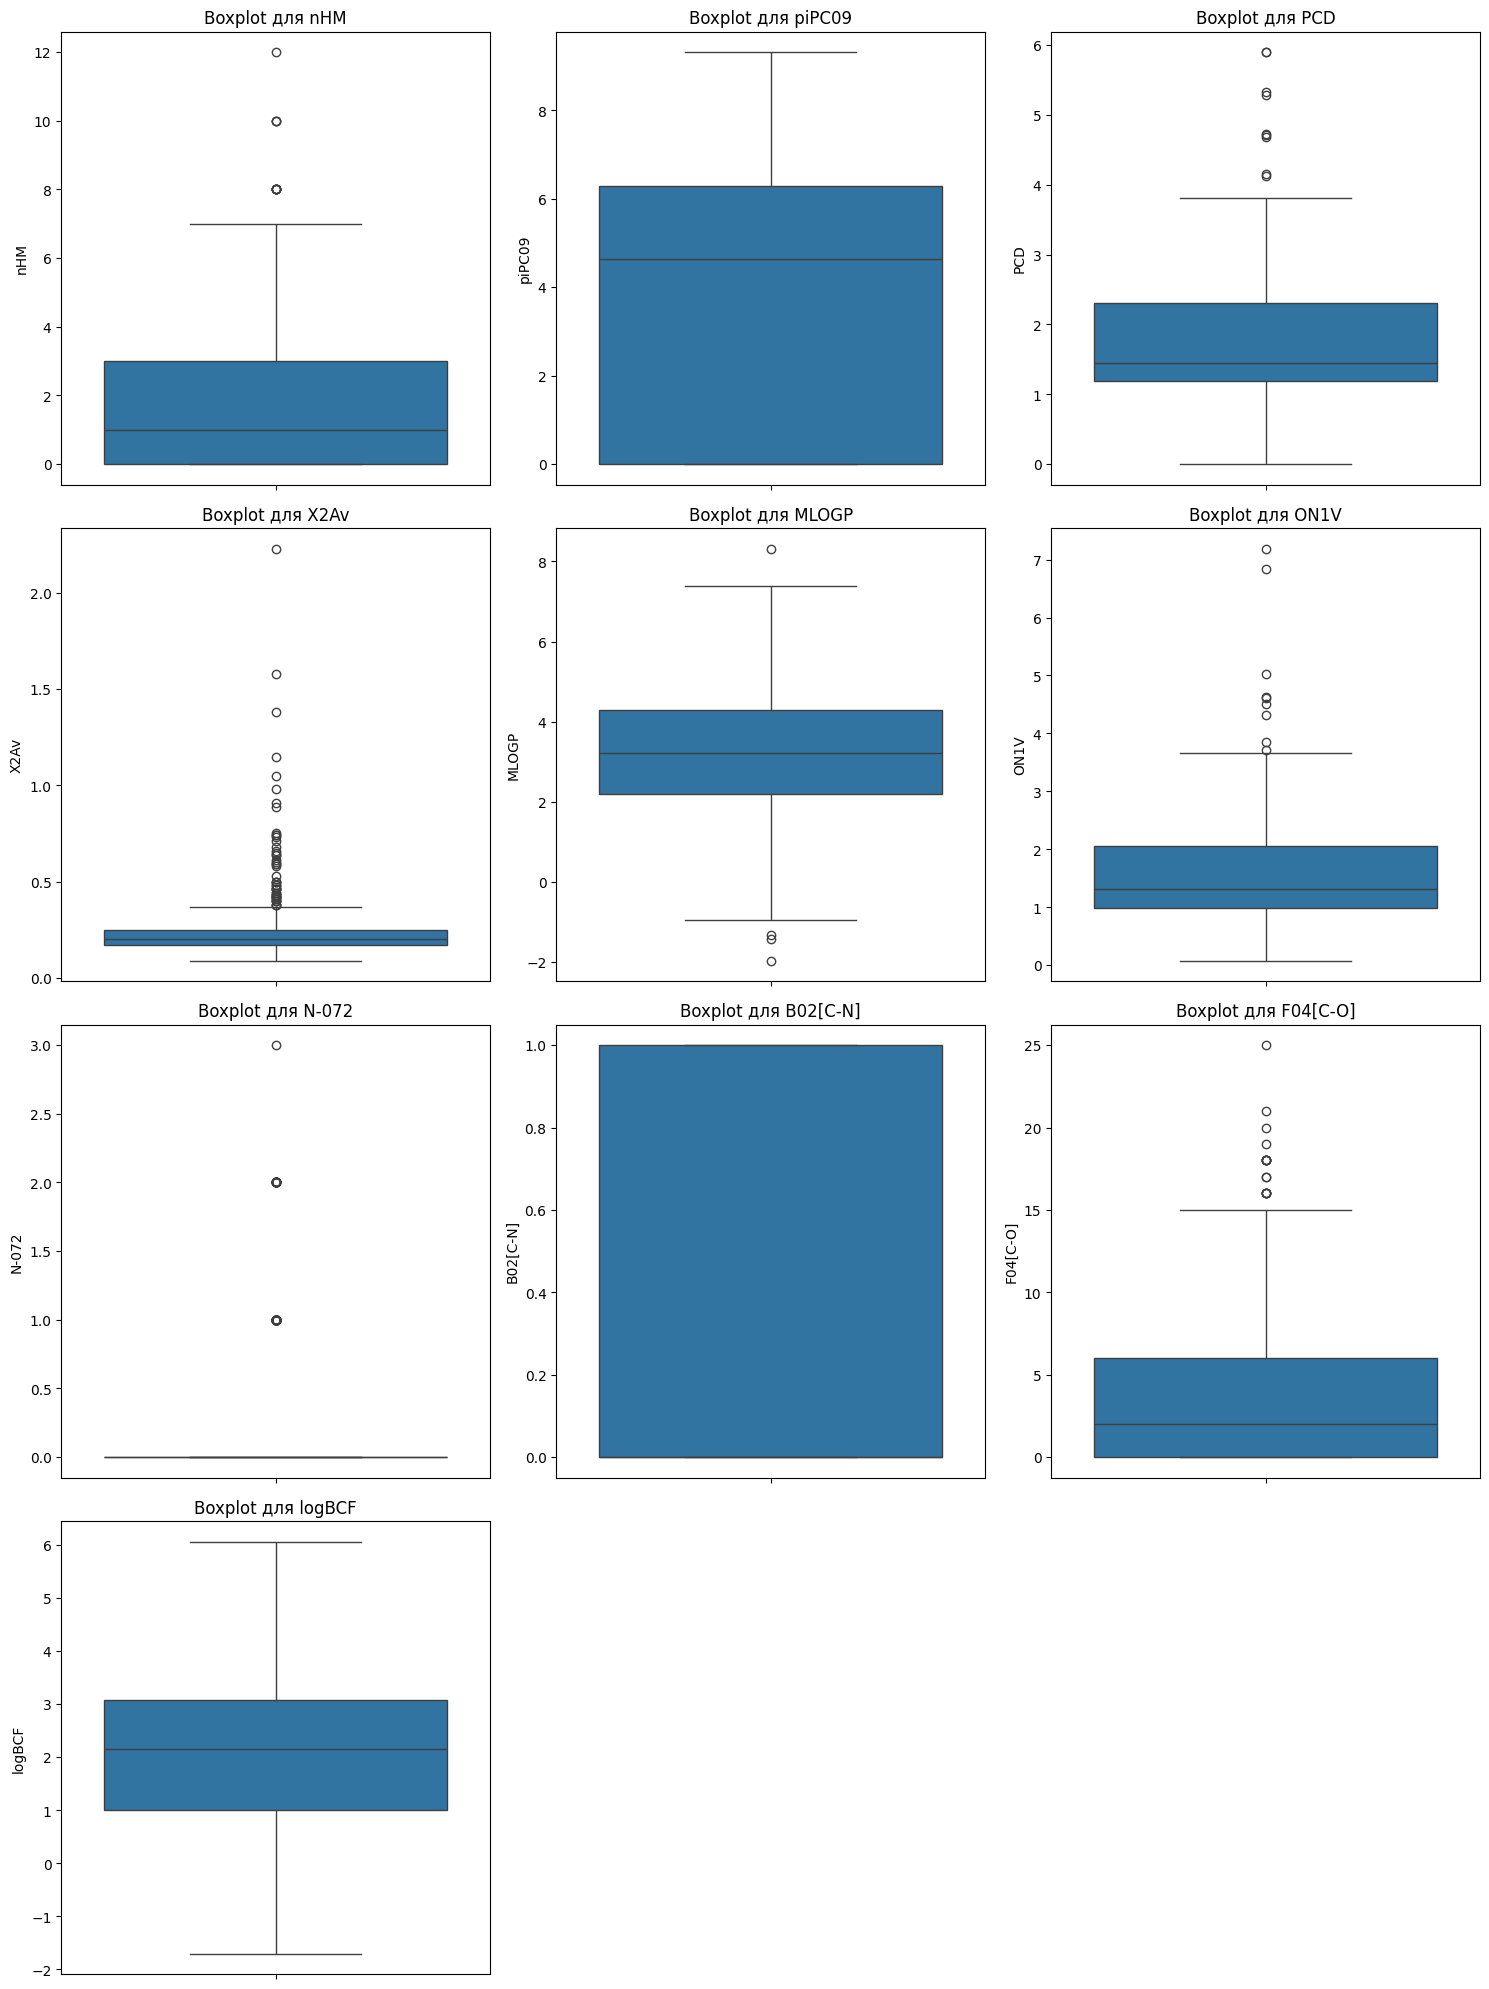

In [11]:
num_cols = len(df.columns)
num_rows = (num_cols + 2) // 3  # по 3 графіки в рядку

plt.figure(figsize=(15, 5 * num_rows))

# Створюємо боксплоти для кожної числової ознаки
for i, col in enumerate(df.columns):
    plt.subplot(num_rows, 3, i + 1)
    sns.boxplot(data=df[col])
    plt.title(f'Boxplot для {col}')

plt.tight_layout()
plt.show()

In [33]:
thresholds = {
    'nHM': (df['nHM'].quantile(0.01), df['nHM'].quantile(0.99)),
    'PCD': (df['PCD'].quantile(0.01), df['PCD'].quantile(0.99)),
    'X2Av': (df['X2Av'].quantile(0.01), df['X2Av'].quantile(0.99)),
    'ON1V': (df['ON1V'].quantile(0.01), df['ON1V'].quantile(0.99)),
    'N-072': (df['N-072'].quantile(0.01), df['N-072'].quantile(0.99)),
    'F04[C-O]': (df['F04[C-O]'].quantile(0.01), df['F04[C-O]'].quantile(0.99)),
}

def remove_outliers(df, thresholds):
    for column, (lower, upper) in thresholds.items():
        df = df[(df[column] >= lower) & (df[column] <= upper)]
    return df

df_cleaned = remove_outliers(df, thresholds)

print(f'Розмір до очищення: {df.shape[0]} рядків')
print(f'Розмір після очищення: {df_cleaned.shape[0]} рядків')

Розмір до очищення: 679 рядків
Розмір після очищення: 645 рядків


In [34]:
def replace_outliers_with_median(df, thresholds):
    for column, (lower, upper) in thresholds.items():
        median = df[column].median()
        df[column] = df[column].mask((df[column] < lower) | (df[column] > upper), median)
    return df

df_cleaned = replace_outliers_with_median(df, thresholds)

In [35]:
df_cleaned

,nHM,piPC09,PCD,X2Av,MLOGP,ON1V,N-072,B02[C-N],F04[C-O],logBCF
0,0,0.0,1.49,0.14,1.35,0.72,0,1,5,0.74
1,0,0.0,1.47,0.14,1.70,0.88,0,1,5,0.93
2,0,0.0,1.20,0.25,4.14,2.06,0,0,0,3.24
3,0,0.0,1.69,0.13,1.89,0.79,0,1,8,-0.40
4,0,0.0,0.52,0.25,2.65,1.31,0,0,0,2.24
...,...,...,...,...,...,...,...,...,...,...
674,3,0.0,1.25,0.21,3.62,0.77,0,0,1,2.84
675,3,0.0,1.25,0.23,4.06,0.62,0,0,0,2.89
676,2,0.0,1.25,0.20,2.73,0.64,0,0,1,1.17
677,6,0.0,0.65,0.32,3.66,1.32,0,0,0,3.82


### Очищені ознаки

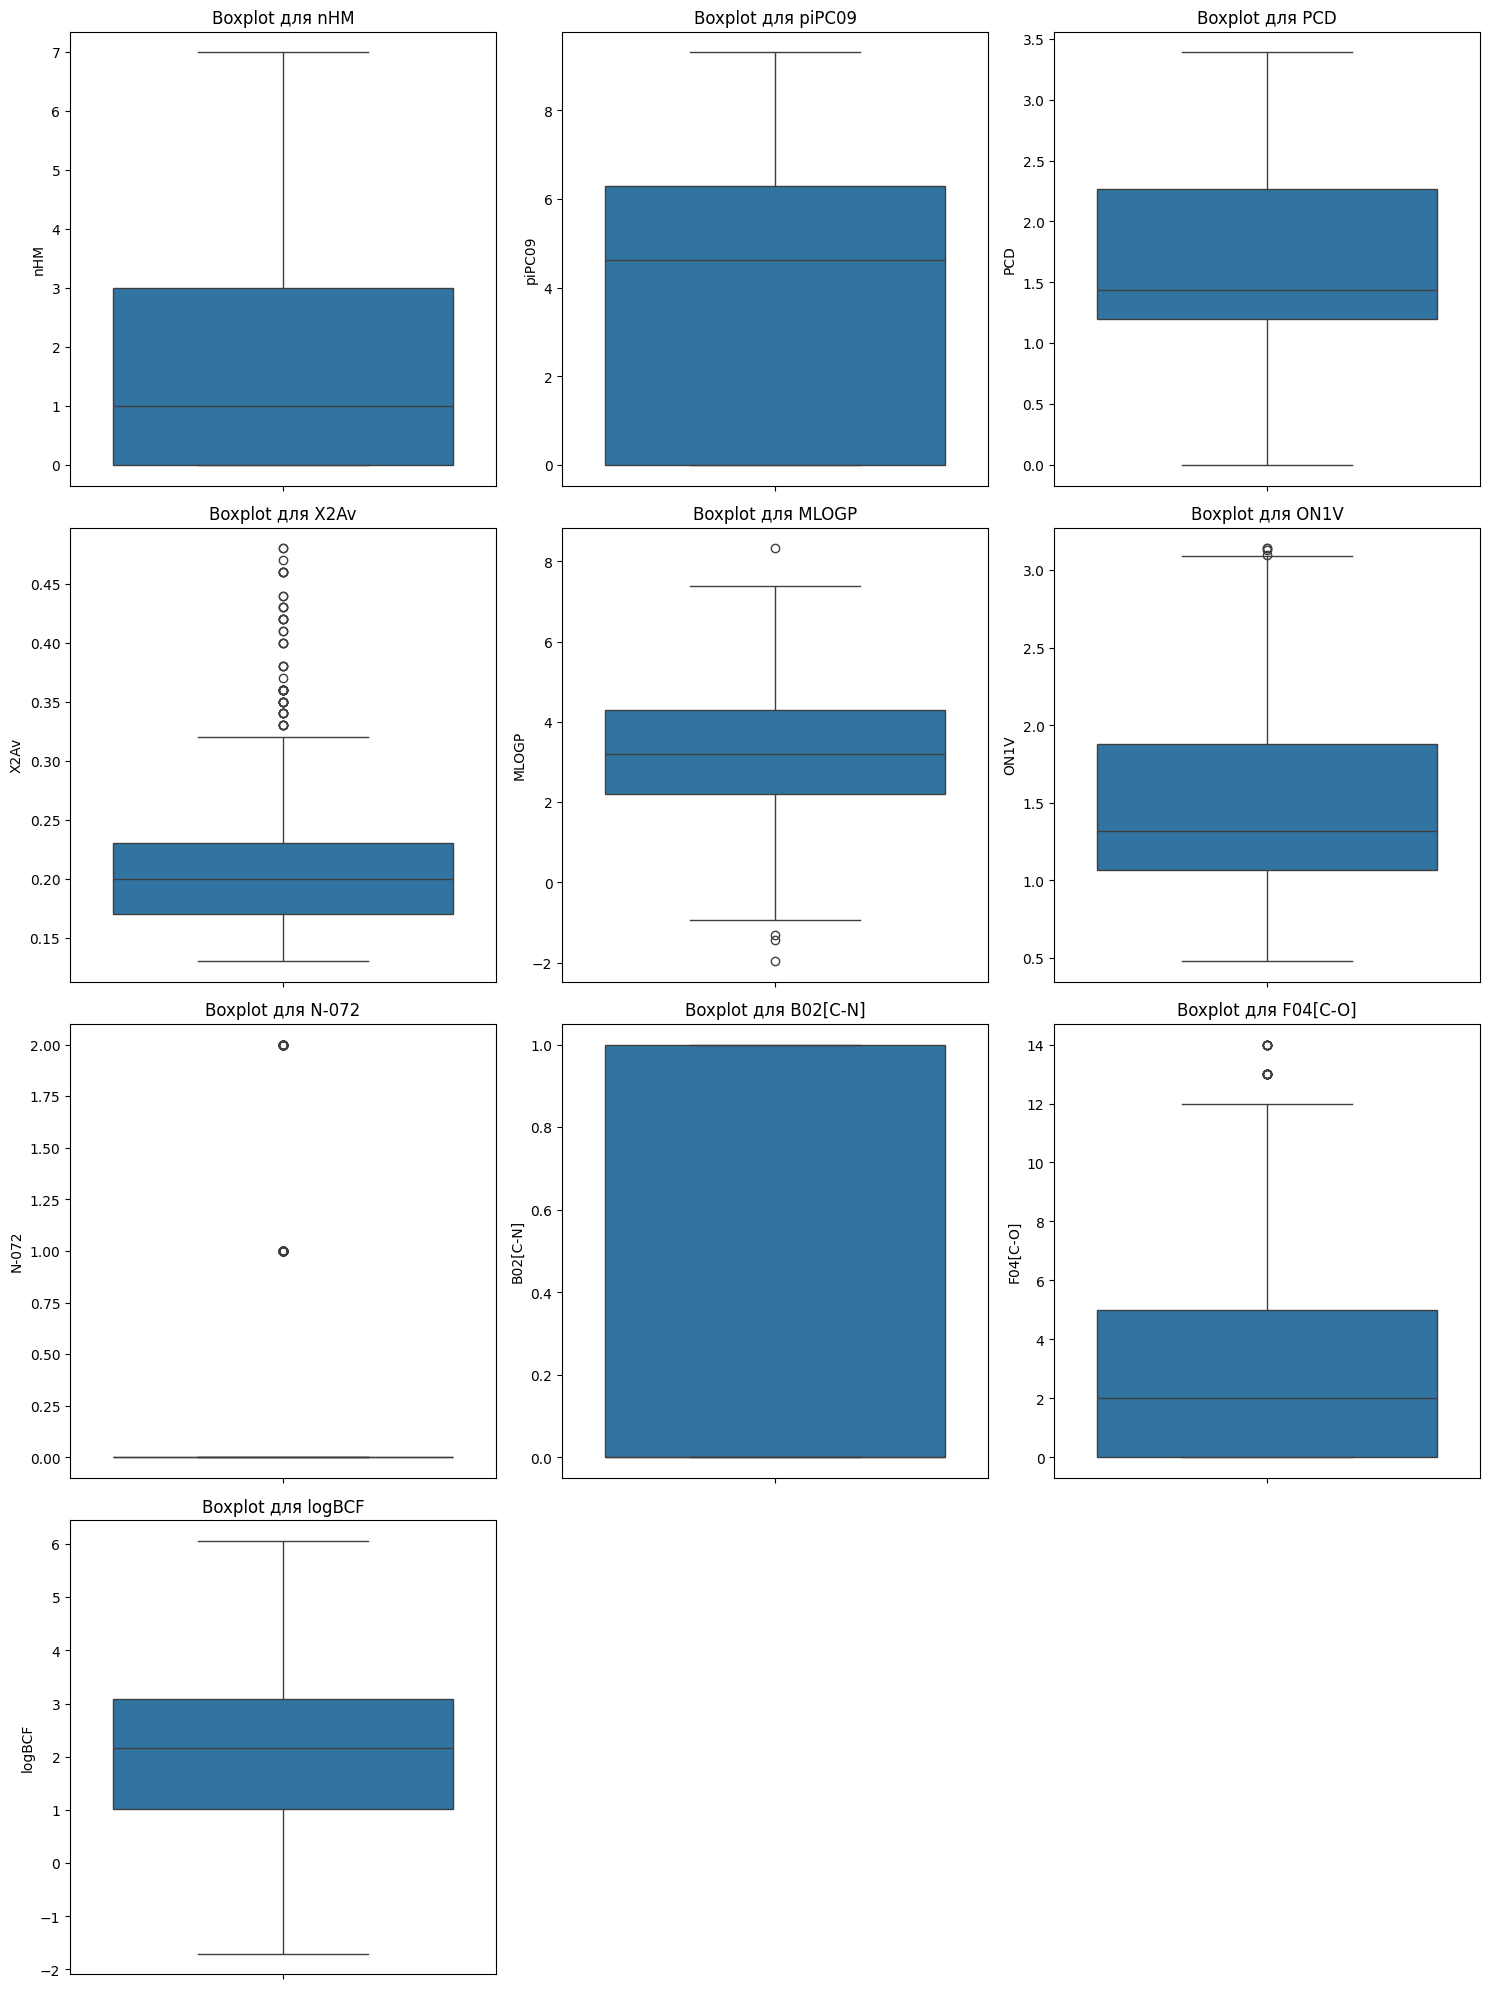

In [32]:
num_cols = len(df_cleaned.columns)
num_rows = (num_cols + 2) // 3  # по 3 графіки в рядку

plt.figure(figsize=(15, 5 * num_rows))

# Створюємо боксплоти для кожної числової ознаки
for i, col in enumerate(df_cleaned.columns):
    plt.subplot(num_rows, 3, i + 1)
    sns.boxplot(data=df_cleaned[col])
    plt.title(f'Boxplot для {col}')

plt.tight_layout()
plt.show()

### Значить коли машина вчиться по таким даним, результати гірші, тому вчити модель по цьому вчити ми не будем :3

In [10]:
X = df.drop(columns=['logBCF'])
y = df['logBCF']

from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

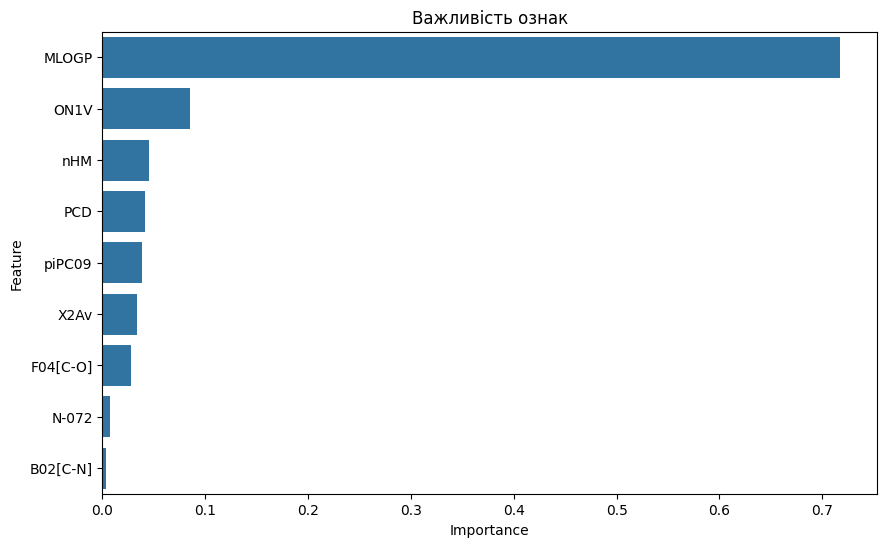

In [37]:
importances = []
feature_names = X.columns

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)

importances = rf.feature_importances_

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Важливість ознак')
plt.show()


## Завдання 2

[9 балів]

### Задача регресії




   
   * Навчити модель `sklearn.ensemble.VotingRegressor` беручи у якості множини базових алгоритмів { `LinearRegression`, `SVR`, `KNeighborsRegressor`, `DecisionTreeRegressor` }  та експерементуючи з параметрами базових алгоритмів та композиції. Знайти коефіцієнт детермінації `R2` для найкращої моделі на відкладеній вибірці.
   
   
   * Навчити модель `sklearn.ensemble.BaggingRegressor` беручи у якості базових алгоритмів `DecisionTreeRegressor` та експерементуючи з параметрами композиції. Знайти коефіцієнт детермінації `R2` для найкращої моделі на відкладеній вибірці.
   
   
   * Навчити модель `sklearn.ensemble.AdaBoostRegressor` беручи у якості базових алгоритмів `DecisionTreeRegressor` та експерементуючи з параметрами композиції. Знайти коефіцієнт детермінації `R2` для найкращої моделі на відкладеній вибірці.
   
   
   * Навчити модель `sklearn.ensemble.GradientBoostingRegressor` беручи у якості базових алгоритмів `DecisionTreeRegressor` та експерементуючи з параметрами композиції. Знайти коефіцієнт детермінації `R2` для найкращої моделі на відкладеній вибірці.
   
   
   * Навчити модель `xgboost.XGBRegressor` беручи у якості базових алгоритмів `gbtree` або `gblinear` або `dart` (розглянути всі варіанти) та експерементуючи з параметрами композиції. Знайти коефіцієнт детермінації `R2` для найкращої моделі на відкладеній вибірці.
   
   
   * Навчити модель `sklearn.ensemble.StackingRegressor`, беручи у якості множини базових алгоритмів { `LinearRegression`, `SVR`, `KNeighborsRegressor`, `DecisionTreeRegressor` } а в якості `final_estimator` : `sklearn.linear_model.RidgeCV` та `sklearn.ensemble.RandomForestRegressor`(розглянути обидва варіанти) та експерементуючи з параметрами базових алгоритмів та композиції. Знайти коефіцієнт детермінації `R2` для найкращої моделі `StackingRegressor`.
   




### 1. **`C` (Регуляризація)** для SVR
$$
\min \frac{1}{2} \|w\|^2 + C \sum_{i=1}^{n} (\xi_i + \xi_i^*)
$$
де \( C \) — це параметр, що контролює баланс між складністю моделі та точністю на тренувальних даних.

### 2. **`kernel` (Ядро)** для SVR
Ядра виконують перетворення вищого порядку. Ось як вони виглядають:

- **Лінійне ядро**:
$$
K(x_i, x_j) = x_i^T x_j
$$
- **RBF (радіально-базисне ядро)**:
$$
K(x_i, x_j) = \exp\left(-\gamma \|x_i - x_j\|^2\right)
$$
- **Поліноміальне ядро**:
$$
K(x_i, x_j) = (\gamma x_i^T x_j + \text{coef0})^d
$$
- **Сигмоїдальне ядро**:
$$
K(x_i, x_j) = \tanh(\gamma x_i^T x_j + \text{coef0})
$$

### 3. **`n_neighbors` (Кількість сусідів)** для KNN
Кількість сусідів для KNN — це просто кількість точок, до яких буде братися відстань. У формулі це відсутнє, але на кожній ітерації обчислюється для \( k \)-тих сусідів.

### 4. **`weights` (Ваги)** для KNN
Якщо обирається `'distance'`, то ваги зважуються за відстанню:
$$
w_i = \frac{1}{d_i}
$$
де \( d_i \) — це відстань до сусіда \( i \). При `'uniform'` ваги рівні для всіх сусідів.

### 5. **`max_depth` (Максимальна глибина дерева)** для DecisionTreeRegressor
Максимальна глибина визначає кількість рівнів дерева. Це обмеження контролює переобладнання дерева.

### 6. **`min_samples_split` (Мінімальна кількість зразків для розбиття вузла)** для DecisionTreeRegressor
Мінімальна кількість зразків, необхідних для поділу вузла:
$$
\text{min\_samples\_split} = m
$$
де \( m \) — кількість зразків у поточному вузлі, необхідних для розбиття.

### 7. **`shrinking` (Зменшення розмірності)** для SVR
Зменшення розмірності прискорює процес оптимізації, але не має прямого математичного еквіваленту. Це впливає на обчислювальний процес.

### 8. **`epsilon` (Параметр \(epsilon\))** для SVR
$$
|y_i - (w \cdot x_i + b)| \leq \epsilon
$$
Цей параметр визначає ширину "трубки", в якій помилки не враховуються у функції втрат.


In [15]:
lr = LinearRegression()
svr = SVR()
knn = KNeighborsRegressor()
dtr = DecisionTreeRegressor()

param_grid = {
    'svr__C': [0.1, 1, 10],
    'svr__kernel': ['linear', 'rbf'],
    'knn__n_neighbors': [0.1, 1, 10],
    'knn__weights': ['uniform', 'distance'],
    'dtr__max_depth': [None, 10, 20],
    'dtr__min_samples_split': [2, 5, 10, 20],
}

voting_reg = VotingRegressor([('lr', lr), ('svr', svr), ('knn', knn), ('dtr', dtr)])

grid_search = GridSearchCV(estimator=voting_reg, param_grid=param_grid, cv=10, scoring='r2', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

print("Найкращі гіперпараметри для VotingRegressor:", grid_search.best_params_)

y_pred_voting = grid_search.predict(X_test_scaled)
r2_voting = r2_score(y_test, y_pred_voting)
print(f'R2 для VotingRegressor: {r2_voting}')

Найкращі гіперпараметри для VotingRegressor: {'dtr__max_depth': 20, 'dtr__min_samples_split': 20, 'knn__n_neighbors': 1, 'knn__weights': 'distance', 'svr__C': 1, 'svr__kernel': 'rbf'}
R2 для VotingRegressor: 0.8219952243335478


In [16]:
dtr = DecisionTreeRegressor()

bagging_reg = BaggingRegressor(estimator=dtr, random_state=42)

param_grid_bagging = {
    'n_estimators': [50, 100, 200],
    'estimator__max_depth': [None, 10, 20],
    'estimator__min_samples_split': [2, 5, 10]
}

grid_search_bagging = GridSearchCV(estimator=bagging_reg, param_grid=param_grid_bagging, cv=5, scoring='r2', n_jobs=-1)

grid_search_bagging.fit(X_train_scaled, y_train)

print("Найкращі гіперпараметри для BaggingRegressor:", grid_search_bagging.best_params_)

y_pred_bagging = grid_search_bagging.predict(X_test_scaled)
r2_bagging = r2_score(y_test, y_pred_bagging)
print(f'R2 для BaggingRegressor: {r2_bagging}')

Найкращі гіперпараметри для BaggingRegressor: {'estimator__max_depth': 10, 'estimator__min_samples_split': 5, 'n_estimators': 100}
R2 для BaggingRegressor: 0.7822101711961393


In [17]:
dtr = DecisionTreeRegressor()

adaboost_reg = AdaBoostRegressor(estimator=dtr, random_state=42)

param_grid_adaboost = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'estimator__max_depth': [None, 10, 20],
    'estimator__min_samples_split': [2, 5, 10]
}

grid_search_adaboost = GridSearchCV(estimator=adaboost_reg, param_grid=param_grid_adaboost, cv=5, scoring='r2', n_jobs=-1)

grid_search_adaboost.fit(X_train_scaled, y_train)

print("Найкращі гіперпараметри для AdaBoostRegressor:", grid_search_adaboost.best_params_)

y_pred_adaboost = grid_search_adaboost.predict(X_test_scaled)
r2_adaboost = r2_score(y_test, y_pred_adaboost)
print(f'R2 для AdaBoostRegressor: {r2_adaboost}')

Найкращі гіперпараметри для AdaBoostRegressor: {'estimator__max_depth': 20, 'estimator__min_samples_split': 10, 'learning_rate': 0.1, 'n_estimators': 100}
R2 для AdaBoostRegressor: 0.7740228518838288


In [18]:
gbr = GradientBoostingRegressor(random_state=42)

param_grid_gbr = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid_search_gbr = GridSearchCV(estimator=gbr, param_grid=param_grid_gbr, cv=5, scoring='r2', n_jobs=-1)

grid_search_gbr.fit(X_train_scaled, y_train)

print("Найкращі гіперпараметри для GradientBoostingRegressor:", grid_search_gbr.best_params_)

y_pred_gbr = grid_search_gbr.predict(X_test_scaled)
r2_gbr = r2_score(y_test, y_pred_gbr)
print(f'R2 для GradientBoostingRegressor: {r2_gbr}')

Найкращі гіперпараметри для GradientBoostingRegressor: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 300}
R2 для GradientBoostingRegressor: 0.7801028704507607


In [19]:
xgb_reg = xgb.XGBRegressor(random_state=42)

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'booster': ['gbtree', 'gblinear', 'dart']
}

grid_search_xgb = GridSearchCV(estimator=xgb_reg, param_grid=param_grid_xgb, cv=5, scoring='r2', n_jobs=-1)

grid_search_xgb.fit(X_train_scaled, y_train)

print("Найкращі гіперпараметри для XGBRegressor:", grid_search_xgb.best_params_)

y_pred_xgb = grid_search_xgb.predict(X_test_scaled)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f'R2 для XGBRegressor: {r2_xgb}')

Найкращі гіперпараметри для XGBRegressor: {'booster': 'gbtree', 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}
R2 для XGBRegressor: 0.7811814902573582


In [20]:
lr = LinearRegression()
svr = SVR()
knn = KNeighborsRegressor()
dtr = DecisionTreeRegressor()

final_estimator_ridge = RidgeCV()
final_estimator_rf = RandomForestRegressor()

param_grid_stacking = {
    'final_estimator': [final_estimator_ridge, final_estimator_rf],
    'svr__C': [0.1, 1, 10],
    'svr__kernel': ['linear', 'rbf'],
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance'],
    'dtr__max_depth': [None, 10, 20],
    'dtr__min_samples_split': [2, 5, 10]
}

stacking_reg = StackingRegressor(
    estimators=[('lr', lr), ('svr', svr), ('knn', knn), ('dtr', dtr)],
    final_estimator=final_estimator_ridge  
)

grid_search_stacking = GridSearchCV(estimator=stacking_reg, param_grid=param_grid_stacking, cv=5, scoring='r2', n_jobs=-1)

grid_search_stacking.fit(X_train_scaled, y_train)

print("Найкращі гіперпараметри для StackingRegressor:", grid_search_stacking.best_params_)

y_pred_stacking = grid_search_stacking.predict(X_test_scaled)
r2_stacking = r2_score(y_test, y_pred_stacking)
print(f'R2 для StackingRegressor: {r2_stacking}')

Найкращі гіперпараметри для StackingRegressor: {'dtr__max_depth': 10, 'dtr__min_samples_split': 2, 'final_estimator': RidgeCV(), 'knn__n_neighbors': 5, 'knn__weights': 'distance', 'svr__C': 10, 'svr__kernel': 'rbf'}
R2 для StackingRegressor: 0.8023341758880204


#  Порівняння результатів найкращих моделей

In [21]:
results = {
    'VotingRegressor': r2_voting,
    'BaggingRegressor': r2_bagging,
    'AdaBoostRegressor': r2_adaboost,
    'GradientBoostingRegressor': r2_gbr,
    'XGBRegressor': r2_xgb,
    'StackingRegressor': r2_stacking
}

best_model_name = max(results, key=results.get)
best_model_r2 = results[best_model_name]
print(f'Найкраща модель: {best_model_name} з R2 = {best_model_r2}')

# Масштабування даних для прогнозування
bio_predict = pd.read_csv("bio_predict.csv") 
bio_predict_scaled = scaler.transform(bio_predict)      

if best_model_name == 'VotingRegressor':
    best_model_pred = grid_search.predict(bio_predict_scaled)
elif best_model_name == 'BaggingRegressor':
    best_model_pred = grid_search_bagging.predict(bio_predict_scaled)
elif best_model_name == 'AdaBoostRegressor':
    best_model_pred = grid_search_adaboost.predict(bio_predict_scaled)
elif best_model_name == 'GradientBoostingRegressor':
    best_model_pred = grid_search_gbr.predict(bio_predict_scaled)
elif best_model_name == 'XGBRegressor':
    best_model_pred = grid_search_xgb.predict(bio_predict_scaled)
elif best_model_name == 'StackingRegressor':
    best_model_pred = grid_search_stacking.predict(bio_predict_scaled)

Найкраща модель: VotingRegressor з R2 = 0.8219952243335478


### Зробити висновки і обрати найкращу модель яка розв'язує задачу регресії. Для найкращої моделі знайти прогнози на вибірці `bio_predict.csv`. Значення прогнозів зберегти у файл `predictions_reg.csv`.



In [22]:
# Зберегти прогнози у змінну best_reg_model_predictions
best_reg_model_predictions = best_model_pred

In [23]:
# Запустити для створення файлу
pd.Series(best_reg_model_predictions).to_csv('predictions_reg.csv')

### Завдання 3

[1 бал]

Зберегти результати роботи у jupyter-ноутбук. Ноутбук повинен бути збережений у стані в якому усі клітинки запущені і не містити помилок. Формат назви файлу `M1_Прізвище_Ім'я.ipynb`

Окремо додати файл `predictions_reg.csv`.


Додатково можна отримати до [4 балів] за порівняннями результатів найкращих моделей завдання 2.